In [ ]:

# importing the modules 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
    
data = pd.read_csv("measurementsGlobalPython3-11Old.csv")
data.info()
powerconsumed = data['Package']
time = (data['Time']/1000.0)
temperature = data['Temperature']
program = data['Program']
powerLimit = data['PowerLimit']


threshold = 3
df = pd.DataFrame({'Program': program, 'PowerLimit': powerLimit, 'Temperature': temperature, 'Energy Consumption': powerconsumed, 'Time': time})

# Recalculate mean after filtering outliers
filtered_df = df[(df['Time'].abs() < df['Time'].mean() + threshold * df['Time'].std()) & 
                (df['Energy Consumption'].abs() < df['Energy Consumption'].mean() + threshold * df['Energy Consumption'].std())]
grouped = filtered_df.groupby(['Program', 'PowerLimit']).mean().reset_index()


# Calculating the ratio between Time and Energy Consumption
#grouped['Ratio'] = grouped['Time'] / grouped['Energy Consumption']


# Getting the energy consumption at PowerLimit -1 for each program
baseline = grouped[grouped['PowerLimit'] == -1][['Program', 'Energy Consumption']]
baseline = baseline.rename(columns={'Energy Consumption': 'Baseline Consumption'})

# Merging the baseline values back into the grouped dataframe
grouped = pd.merge(grouped, baseline, on='Program')

# Calculating the ratio of energy consumption to the baseline
grouped['Ratio'] = grouped['Energy Consumption'] / grouped['Baseline Consumption']

# dfCorr = grouped[['PowerLimit','Temperature',"Time","Energy Consumption"]]
# dfCorr['PowerLimit'].replace(-1, 51, inplace=True)
# print(dfCorr)
# corr = dfCorr.corr()
# plt.figure(figsize=(11,8))
# sns.heatmap(corr, cmap="Greens",annot=True)
# plt.show()


# Pivoting the dataframe to create a matrix
heatmap_data = grouped.pivot(index="PowerLimit", columns="Program", values="Ratio")


# Plotting the heatmap
plt.figure(figsize=(10, 8))
hm = sns.heatmap(data=heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Ratio of Power Consumption')
plt.show()


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dataCap = pd.read_csv("measurementsGlobalNewWithPowerCap.csv")
dataNoCap = pd.read_csv("measurementsGlobalNewNoPowerCap.csv")
dataNoCap = dataNoCap[dataNoCap["Program"].isin(dataCap["Program"])]
fullData = pd.concat([dataNoCap, dataCap])

powerconsumed = fullData["Package"]
time = fullData["Time"] / 1000.0
temperature = fullData["Temperature"]
program = fullData["Program"]
pythonVersion = fullData["Language"]
powerLimit = fullData["PowerLimit"]


threshold = 3
df = pd.DataFrame(
    {
        "Program": program,
        "PowerLimit": powerLimit,
        "Temperature": temperature,
        "EnergyConsumption": powerconsumed,
        "Time": time,
        "PythonVersion": pythonVersion,
    }
)
df["Program"] = df["Program"].str.strip()
df["PythonVersion"] = df["PythonVersion"].map({"Python38":"Python 3.8","Python310":"Python 3.10","Python311": "Python 3.11"})
df["PowerLimit"] = df["PowerLimit"].map({-1: "Uncapped",10:"Capped"})
def remove_outliers(group, threshold):
    # Calculate mean and standard deviation for 'Time' and 'Energy Consumption'
    time_mean = group['Time'].mean()
    time_std = group['Time'].std()
    energy_mean = group['EnergyConsumption'].mean()
    energy_std = group['EnergyConsumption'].std()
    
    # Filter out the outliers
    filtered_group = group[
        (group['Time'].abs() < time_mean + threshold * time_std) & 
        (group['EnergyConsumption'].abs() < energy_mean + threshold * energy_std)
    ]
    return filtered_group


groupedBefore = df.groupby(['Program', 'PowerLimit'])
threshold = 3
filtered_df = groupedBefore.apply(lambda x: remove_outliers(x, threshold)).reset_index(drop=True)

/tmp/ipykernel_31041/3905760436.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = groupedBefore.apply(lambda x: remove_outliers(x, threshold)).reset_index(drop=True)


In [42]:
group_powerlimit = filtered_df[["PowerLimit","Time","EnergyConsumption","PythonVersion"]].groupby(["PythonVersion","PowerLimit"]).mean().reset_index()
print(group_powerlimit)

  PythonVersion  PowerLimit       Time  EnergyConsumption
0     Python310          -1  38.398335         736.912098
1     Python310          10  46.148245         458.436397
2     Python311          -1  35.431240         678.679543
3     Python311          10  40.077759         397.948986
4      Python38          -1  40.168277         768.869852
5      Python38          10  47.803652         475.059897


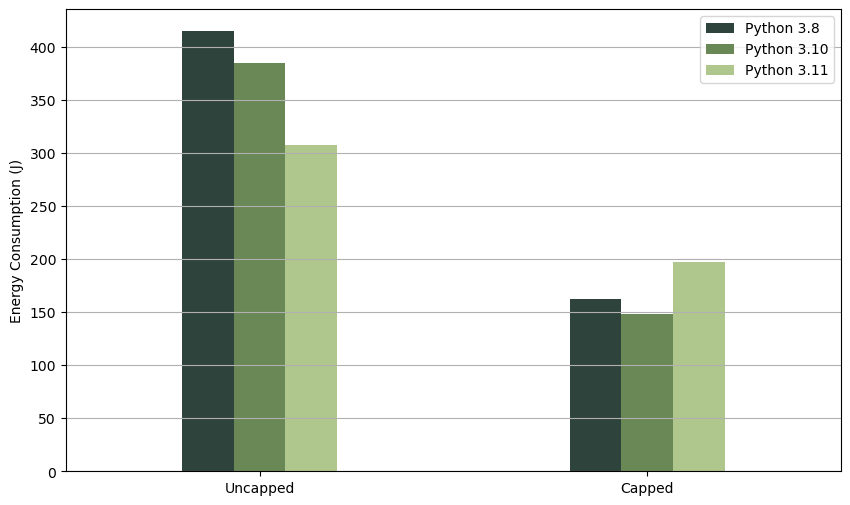

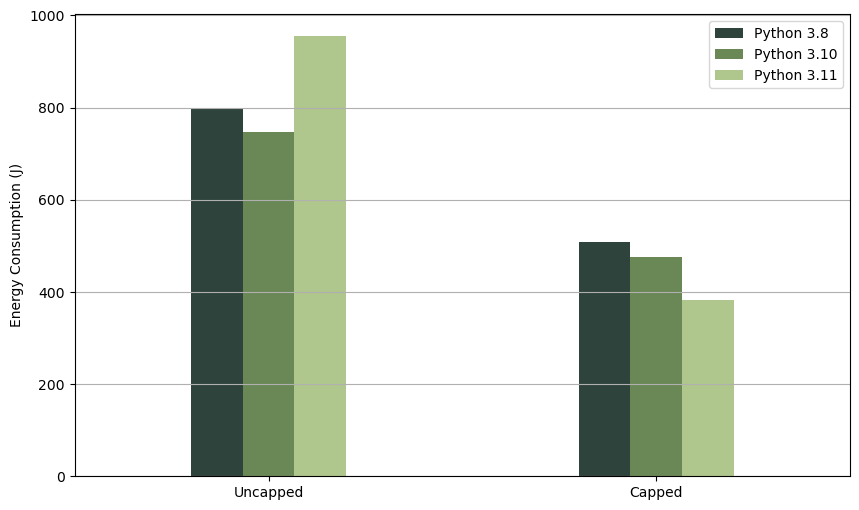

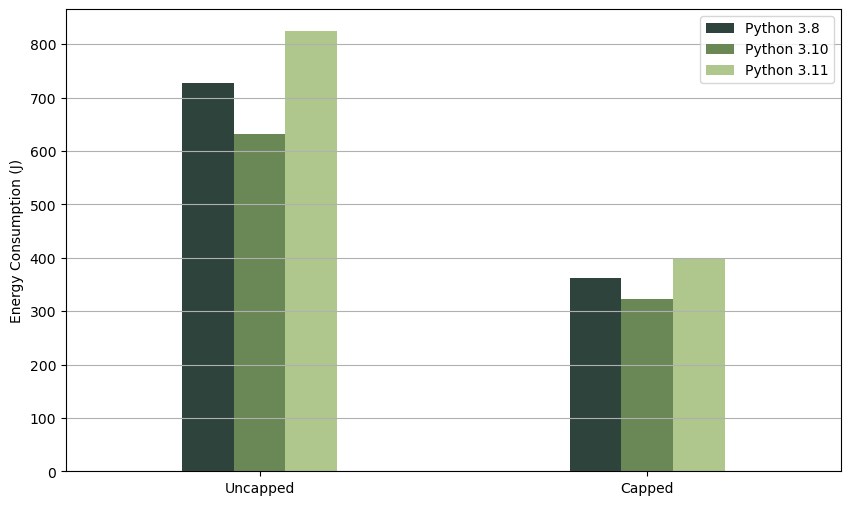

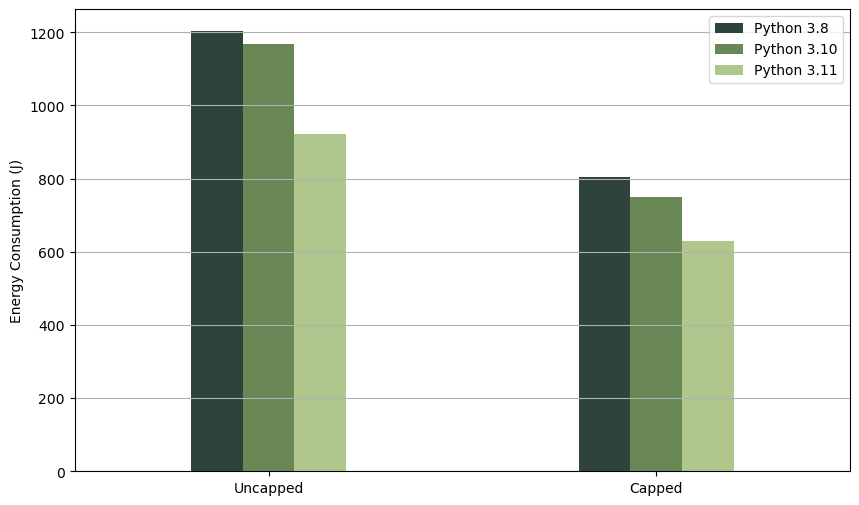

In [66]:
##### single case graph #####
python_versions = ["Python 3.8","Python 3.10","Python 3.11"]
for benchmark_name in ["html5lib","deepcopy","concurrent_imap","dask"]:
    single_case_df = filtered_df[filtered_df["Program"] == benchmark_name].drop(columns="Program").groupby(["PythonVersion","PowerLimit"]).mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=single_case_df, x='PowerLimit', y='EnergyConsumption',hue = "PythonVersion",hue_order=python_versions, width=0.4, palette=["#2B463C","#688F4E","#B1D182"], order = ["Uncapped","Capped"])
    plt.xlabel('')
    plt.ylabel('Energy Consumption (J)')
    plt.grid(axis='y')
    plt.legend()
    plt.savefig(f"images/{benchmark_name}.png",bbox_inches = "tight")
    plt.show()

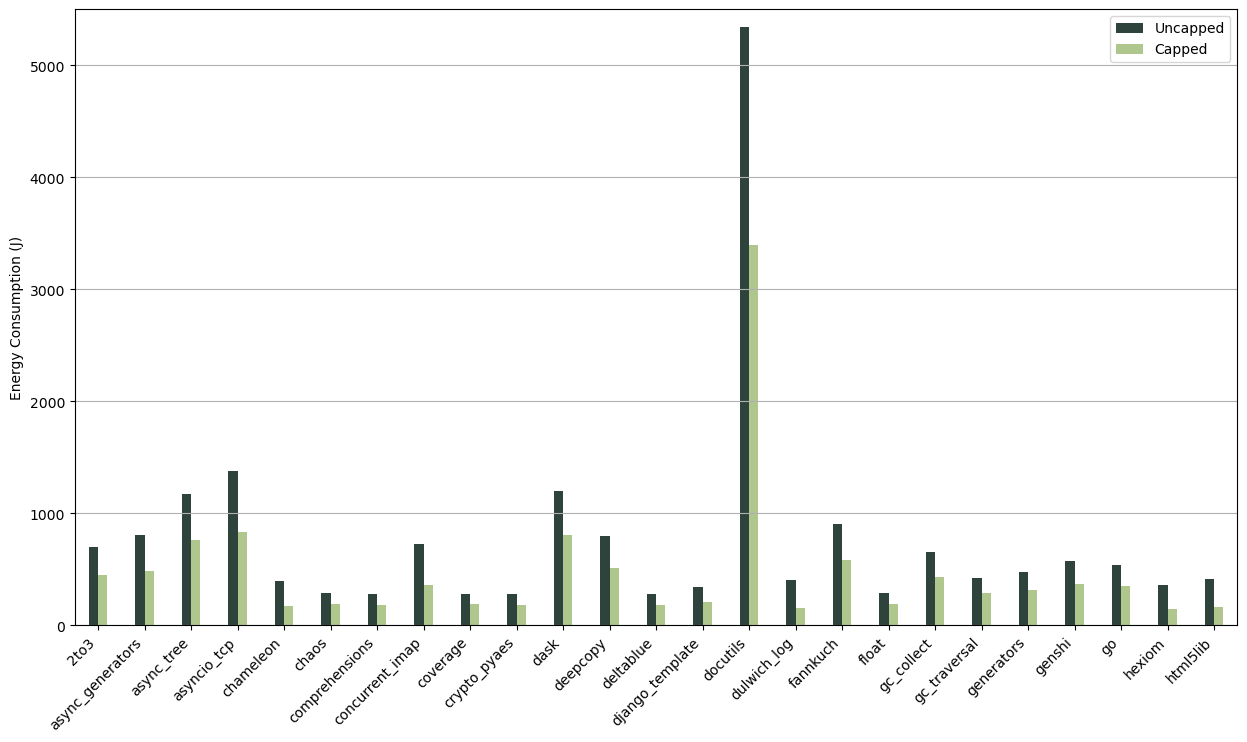

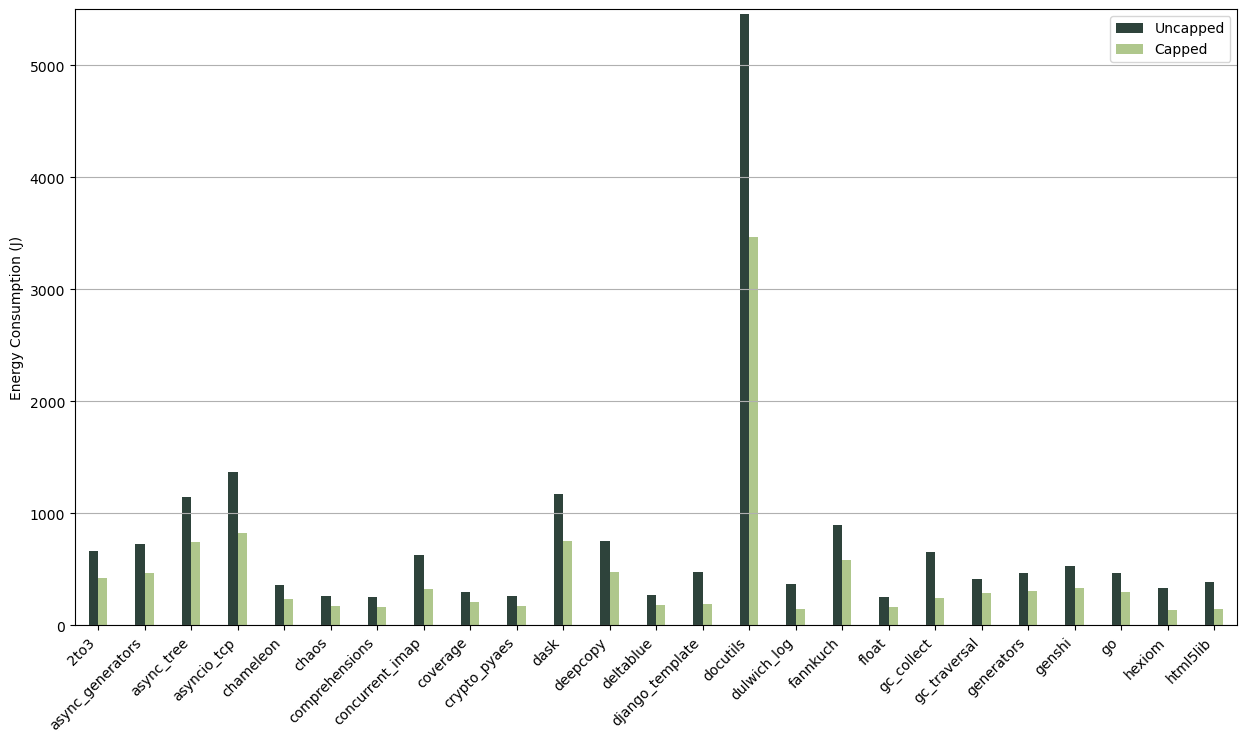

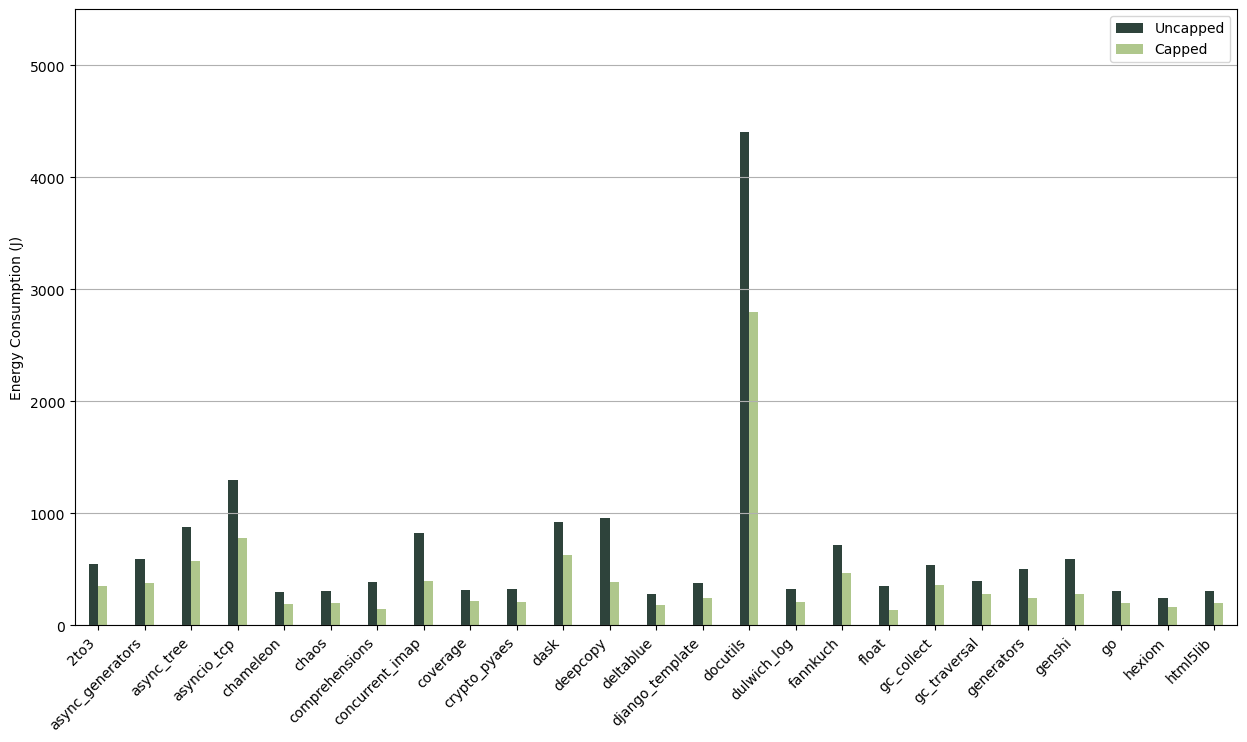

In [65]:
##### All benchamarks per version #####
for version in python_versions:
    version_df = filtered_df[filtered_df["PythonVersion"]==version].drop(columns="PythonVersion")
    grouped_prog_limit = version_df.groupby(["Program", "PowerLimit"]).mean().reset_index()
    plt.figure(figsize=(15, 8))
    sns.barplot(data=grouped_prog_limit, x='Program', y='EnergyConsumption', hue='PowerLimit',hue_order = ["Uncapped","Capped"], width=0.4, palette=["#2B463C","#B1D182"])
    plt.xlabel("")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Energy Consumption (J)')
    plt.grid(axis='y')
    plt.legend()
    plt.ylim(0,5500)
    plt.savefig(f"images/all-benchmarks-{version}.png",bbox_inches = "tight")
    plt.show()